# Experiments with HAM10000

To avoid further confusion by libraries' dependency, we resized the image's height from 450 and width from 600 to 300 and 300 pixels, respectively.

In [35]:
%load_ext autoreload
%autoreload 2
    
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

import imageprocessing
from imageprocessing import ImageResize, MaskedImage
from kerasmodels import CreateGenerator, CNNModel
import attacks
from skincolors import IndividualTypologyAngle
from distance import DistanceMeasure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load dataset

In [36]:
db = "HAM"
root = f"../../dataset/IEEE/{db}/"

train_df = pd.read_csv(f"{root}exp/train_df.csv")
valid_df = pd.read_csv(f"{root}exp/valid_df.csv")
test_df = pd.read_csv(f"{root}exp/test_df.csv")

In [37]:
train_df["labels"] = train_df["labels"].astype(str)
valid_df["labels"] = valid_df["labels"].astype(str)
test_df["labels"] = test_df["labels"].astype(str)

## Create image generator

In [38]:
sample_image_path = train_df["filepath"].iloc[0]
img_size = imageprocessing.get_image_size(sample_image_path)
print("H*W: ", img_size)

H*W:  (300, 300)


In [39]:
batch_size=8
img_size = img_size
cg = CreateGenerator(img_size, batch_size)
train_gen = cg.train_generator(train_df)
valid_gen = cg.valid_generator(valid_df)
test_gen = cg.valid_generator(test_df)

Found 2000 validated image filenames belonging to 2 classes.
Found 1563 validated image filenames belonging to 2 classes.
Found 1564 validated image filenames belonging to 2 classes.


## Training

In [40]:
import torch
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
import keras

keras.utils.set_random_seed(42)

# Load the ResNet50 model with pre-trained ImageNet weights, excluding the top fully connected layer
base_model = ResNet50(weights="imagenet", include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=outputs)

model.compile(Adam(learning_rate= 0.00001), loss= "binary_crossentropy", metrics= ["accuracy"])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [41]:
epochs = 20
callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[callback])

Epoch 1/20


/home/kuniko/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.7422 - loss: 0.5138 - val_accuracy: 0.1420 - val_loss: 37.6715
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.8173 - loss: 0.3734 - val_accuracy: 0.1420 - val_loss: 59.0845
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.8519 - loss: 0.3300 - val_accuracy: 0.1472 - val_loss: 45.6128
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.8709 - loss: 0.2964 - val_accuracy: 0.6148 - val_loss: 1.3083
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.8987 - loss: 0.2554 - val_accuracy: 0.9111 - val_loss: 0.2236
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9036 - loss: 0.2315 - val_accuracy: 0.8976 - val_loss: 0.2558
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9188 - loss: 0.1929 - val_accuracy: 0.8669 - val_loss: 0.3375
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9308 - loss: 0.1998 - val_accu

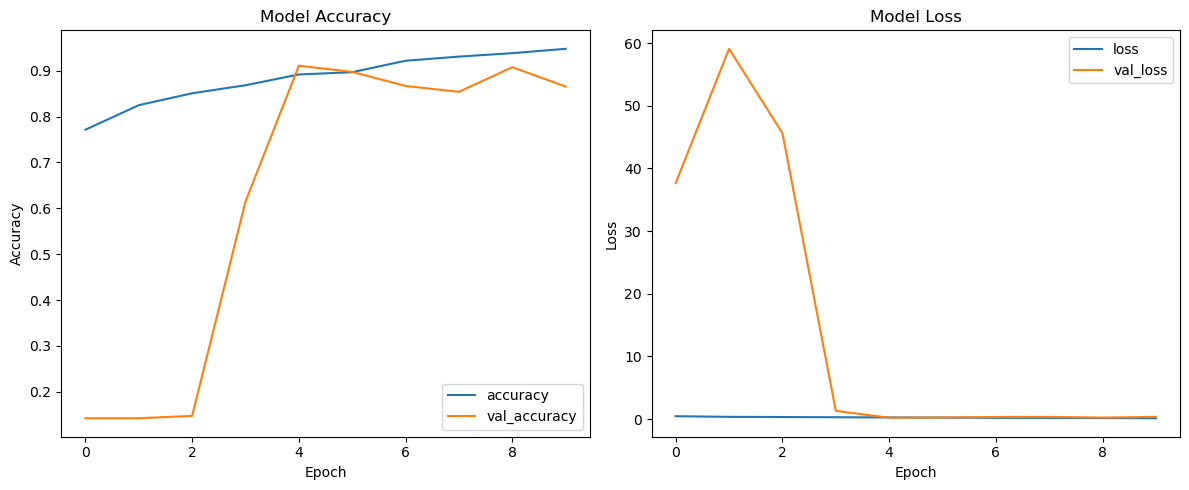

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax[0].plot(history.history["accuracy"], label="accuracy")
ax[0].plot(history.history["val_accuracy"], label="val_accuracy")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc="lower right")
ax[0].set_title("Model Accuracy")

# Loss
ax[1].plot(history.history["loss"], label="loss")
ax[1].plot(history.history["val_loss"], label="val_loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc="upper right")
ax[1].set_title("Model Loss")

plt.tight_layout()
plt.show()

## Evaluation

In [43]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)
pred = model.predict(test_gen, verbose=0)
pred_class = ["1" if p[0] >= 0.5 else "0" for p in pred]

196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8992 - loss: 0.2548
Test Loss 0.27489253878593445
Test Accuracy 0.8919437527656555


In [44]:
test_df["pred"] = pred_class
print(classification_report(test_df["labels"], test_df["pred"]))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1341
           1       0.81      0.31      0.45       223

    accuracy                           0.89      1564
   macro avg       0.86      0.65      0.70      1564
weighted avg       0.88      0.89      0.87      1564



# Adversarial Attacks

## Random Noise

True label: 1
Prediction: [[0.38212427]]
Prediction class: ['0']
Adversarial Prediction: [[0.02461393]]
Adversarial Predicted Class: ['0']


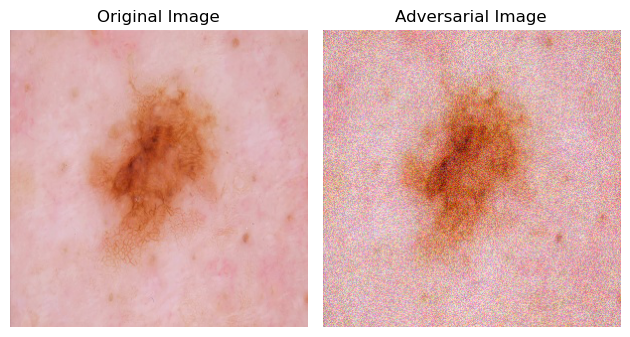

In [62]:
np.random.seed(42)
filepath = f"{root}data/ISIC_0026105.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.15
attacks.random_noise_attack_with_image(model, filepath, true_label, eps)

In [63]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.random_noise_attack(model, d["filepath"], d["labels"], eps))

In [64]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["RN pred"] = adv_pred
test_df["RN pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "RN")

RN Success rate: 0.04283887468030691
RN TN Success rate: 0.021099744245524295
RN FP Success rate: 0.021739130434782608


## FGSM

True label: 1
Prediction: [[0.38212427]]
Prediction class: ['0']
Adversarial Prediction: [[0.01797737]]
Adversarial Predicted Class: ['0']


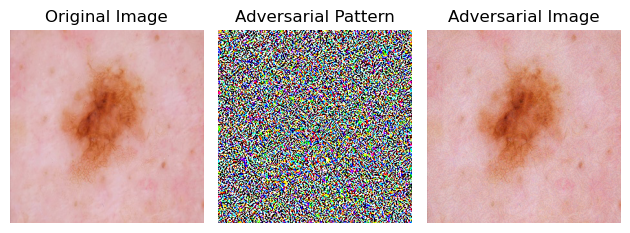

In [48]:
filepath = f"{root}data/ISIC_0026105.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.02
adv = attacks.fgsm_attack_with_image(model, filepath, true_label, eps)

In [49]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.fgsm_attack(model, d["filepath"], d["labels"], eps))

In [50]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["FGSM pred"] = adv_pred
test_df["FGSM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "FGSM")

FGSM Success rate: 0.27429667519181583
FGSM TN Success rate: 0.23337595907928388
FGSM FP Success rate: 0.04092071611253197


## Saliency Map Attack

True label: 0
Prediction: [[0.0393814]]
Prediction class: ['0']
Adversarial Prediction: [[0.02585127]]
Adversarial Predicted Class: ['0']


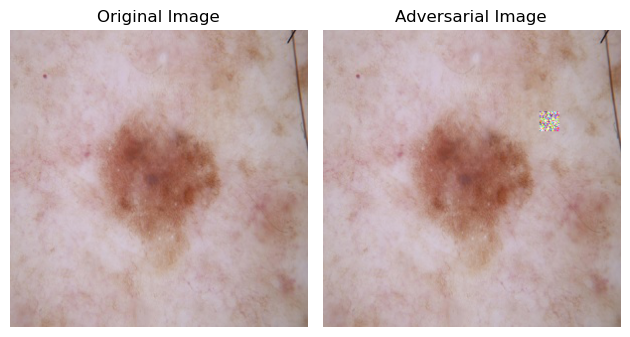

In [51]:
# filepath = f"{root}data/ISIC_0026105.jpg"
filepath = f"{root}data/ISIC_0030733.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.5
patch_size=20
attacks.sailency_attack_with_image(model, filepath, true_label, eps, patch_size)

In [52]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.saliency_attack(model, d["filepath"], d["labels"], eps, patch_size))

In [53]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["SM pred"] = adv_pred
test_df["SM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "SM")

SM Success rate: 0.010230179028132993
SM TN Success rate: 0.008312020460358057
SM FP Success rate: 0.0019181585677749361


## Data export for analysis

In [66]:
test_df.to_csv(f"{root}/exp/test_df_HAM10000_ResNet.csv", index=False)